In [170]:
%matplotlib inline 
import scipy
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import PyDSTool as dst
import copy
from tqdm import tqdm

$$
\frac{dB_M}{dt} = B_{M,source} - \frac{k_{AD}B_M}{k_3+B_M} - \frac{k_{AT}R_EB_M}{\alpha_{EM}+R_E} - \epsilon B_{M}
$$
$$
\frac{d\epsilon}{dt} = \frac{\epsilon_0 - \epsilon}{\tau} + fP(\epsilon_{max}-\epsilon)
$$
$$
\frac{dR_E}{dt} = \frac{a_{1} B_M T_I}{(\gamma_{1}+B_M)(1+\alpha_{RE}I_E)}+\frac{k_1P}{1+\alpha_{RE}I_E}-\mu_{RE}R_E
$$
$$
\frac{dI_E}{dt} = \frac{k_{IE}R_E}{\gamma_{IE}+R_E}+\alpha_{11}B_M-\mu_{IE}I_E
$$
$$
\frac{dB}{dt} = [\epsilon B_M-T]_+ - k_5PB
$$
$$
\frac{dP}{dt} = \frac{k_{PM}B}{\gamma_{12}+B} + \frac{k_{PE}[R_E-T_{RE}]_+}{1+\gamma_{PE}I_{E}}-\mu_4P
$$

In [210]:
# variable_dict = {
#     'B_M':'B_MSource - (k_AD*B_M)/(k_3+B_M) - (k_AT*R_E*B_M)/(alpha_EM+R_E)-epsilon*B_M',
#     'epsilon':'(epsilon_0-epsilon)/tau_p + f*P*(epsilon_max-epsilon)',
#     'R_E': '(a_1*B_M*(k_1*P+T_I))/((gamma_1+B_M)*(1+alpha_RE*I_E))-mu_RE*R_E',
#     'I_E': '(k_IE*R_E)/(gamma_IE+R_E)+alpha_11*B_M-mu_IE*I_E',
#     'B':'max(0,epsilon*B_M-T) -k_5*P*B',
#     'P':'(k_PM*B)/(gamma_12+B)+(k_PE*max(0,R_E-T_RE))/(1+gamma_PE*I_E)-mu_4*P',
#     'Ep': 'mu_E*(Ep/(Ep+gamma_E))-(d1+d2*P)*Ep'
    
# }
variable_dict = {
    'B_L': 'B_MSource - k_dif*(B_L/V_L - B_M/V_M) - d_BL*B_L',
    'B_M':'k_dif*(B_L/V_L-B_M/V_M) - (k_AD*B_M)/(k_3+B_M) - (k_AT*R_E*B_M)/(alpha_EM+R_E)-(epsilon_0+epsilon_E*(E_max-E)^n/((1+(E_max-E)^n)))*B_M',
    'R_E': '(a_1*B_M*(k_1*P+T_I))/((gamma_1+B_M)*(1+alpha_RE*I_E))-mu_RE*R_E',
    'I_E': '(k_IE*R_E)/(gamma_IE+R_E)+alpha_11*B_M-mu_IE*I_E',
    'B':'max(0, (epsilon_0+epsilon_E*(E_max-E)^n/((1+(E_max-E)^n))*B_M-T)) -k_5*P*B + mu_B*B',
    'P':'((k_PM*B)/(gamma_12+B))*(0.5+P/(P+1))+(k_PE*max(0,R_E-T_RE))/(1+gamma_PE*I_E)-mu_4*P',
    'Ep': 'mu_E*(Ep/(Ep+gamma_E))-(d1+d2*P)*Ep'
    
}


d1= 0.125/4
gamma_E=0.5
mu_E=0.5/4
E_max = (mu_E-gamma_E*d1)/d1
parameter_dict = {
    'V_L': 1,
    'V_M':0.5,
    'd_BL':0.5,
    'k_dif': 5,
    'B_MSource':3e6, #1.5e6,#
    'k_AD':1.5e6,#
    'k_3':6e6,
    'k_AT':0.03,
    'alpha_EM':0.18,
    'epsilon_0':0.1,
    'epsilon_max':0.21,
    'tau_p':24,
    'f':0.5,
    'a_1':0.5,#
    'gamma_1':5e6,
    'k_1':1,
    'alpha_RE':2,
    'mu_RE':0.1,
    'k_IE':19,#
    'gamma_IE':10,
    'alpha_11':0.1e-7,
    'mu_IE':1,
    'T':1.1e6,
    'k_5':5,
    'k_PM':0.05,
    'gamma_12':1.2e5,
    'k_PE':0.002,
    'T_RE':0.65,
    'gamma_PE':1,
    'mu_4':0.05,
    'T_I':1, 
    'mu_E': mu_E,
    'gamma_E':gamma_E,
    'd1': d1,
    'd2': 0.625/8,
    'E_max': E_max,
    'epsilon_E': 0.1,
    'mu_B':0.4,
    'n': 1
}
#notebook
initial_conditions = {
    'B_L':1e6,
    'B_M':0,
#     'epsilon':0.1,
    'R_E':0,
    'I_E':0,
    'B':0,
    'P':0,
    'Ep':3.5
}

ModelDefinition=dst.args(name="2013 Aciero Model",
                        varspecs=variable_dict,
                        pars=parameter_dict,
                        ics=initial_conditions,
                        tdata=[0,300])
ModelDS = dst.Vode_ODEsystem(ModelDefinition)

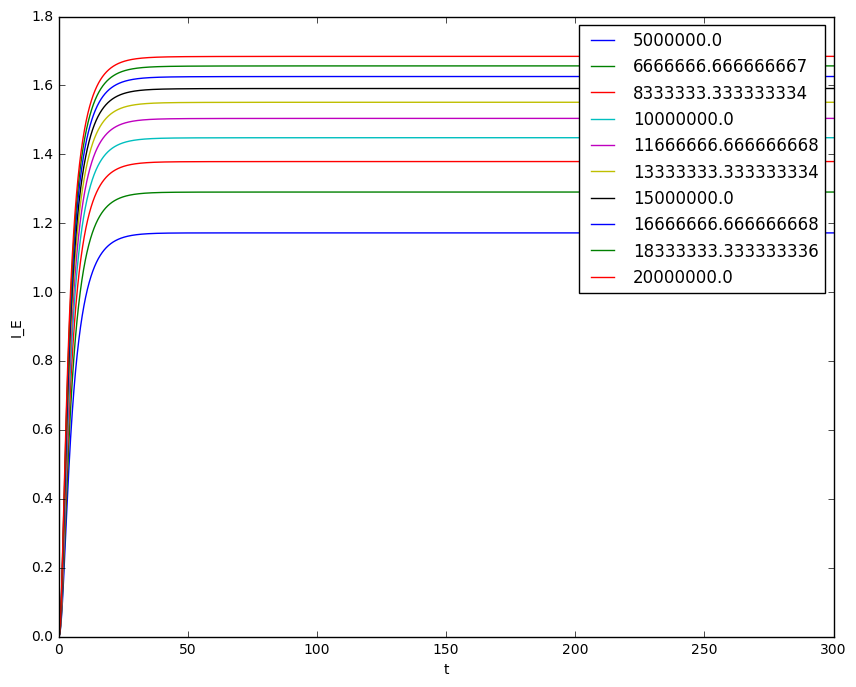

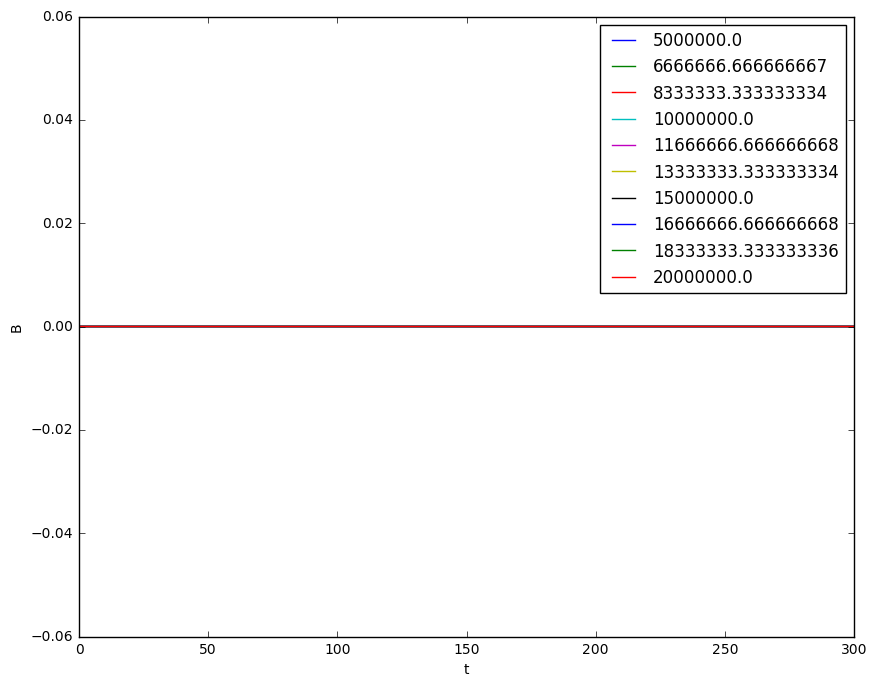

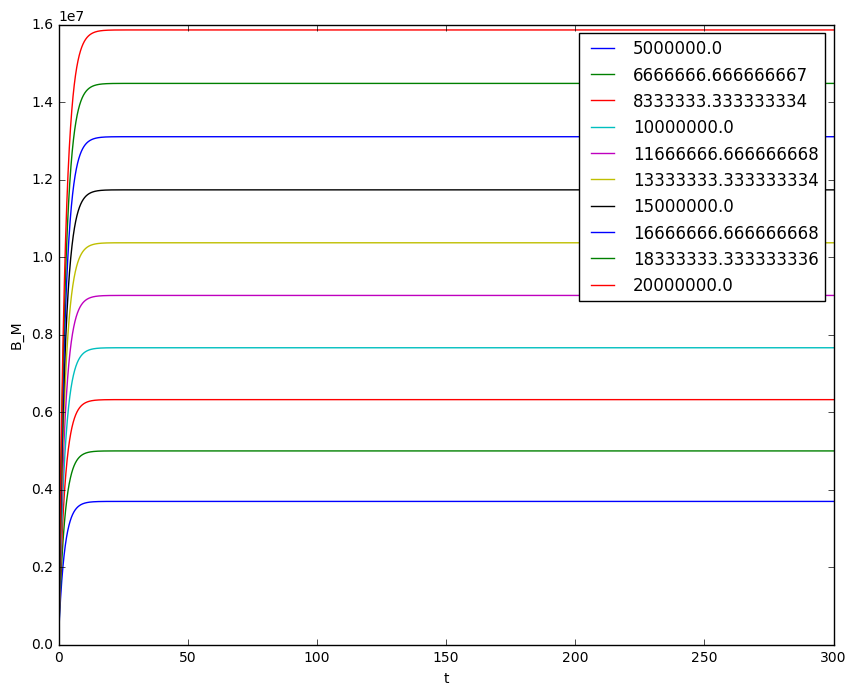

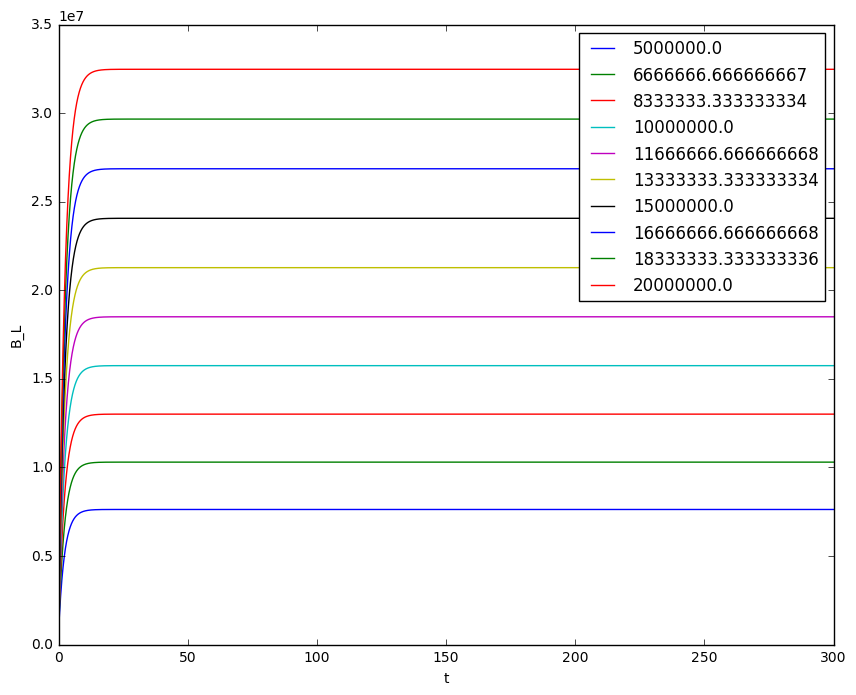

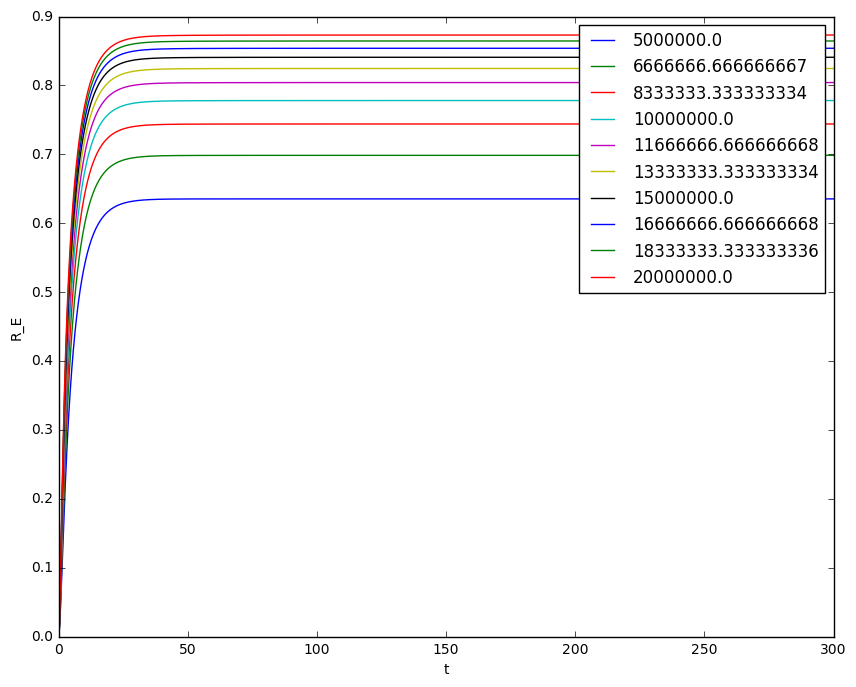

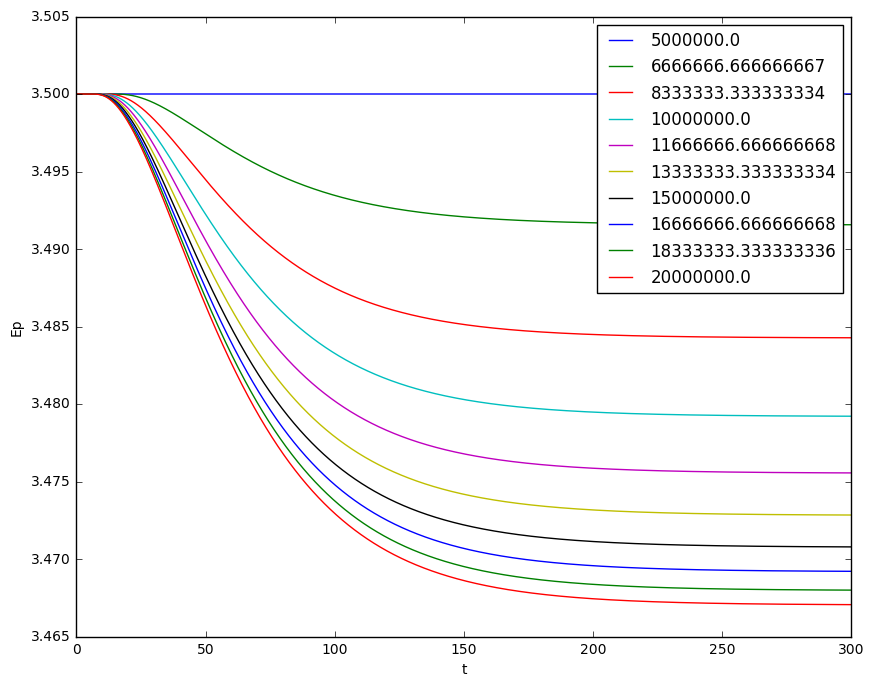

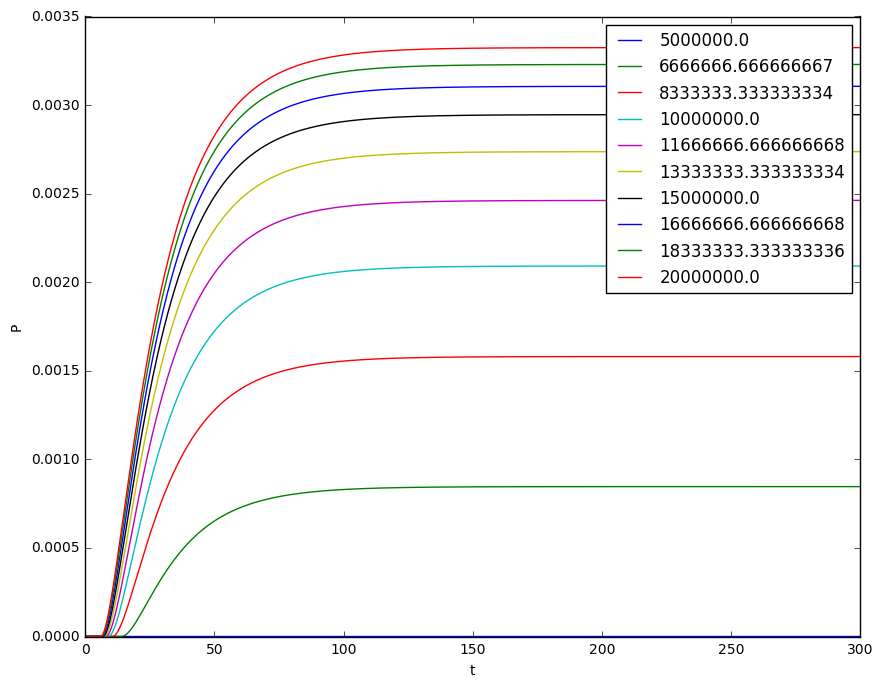

NameError: name 'epsilon_0' is not defined

In [212]:
plt.figure(figsize=(10,8))
paramofInterest = 'B_MSource'
SearchP = np.linspace(5e6,2e7,10)
AllPoints = []
for p in range(0, len(SearchP)):
    param=SearchP[p]
    ModelDS.set(pars={paramofInterest:param},
                tdata=[0,300])
    P = ModelDS.compute('bbtest').sample()
    AllPoints.append(P)

for var in variable_dict.keys():
    plt.figure(figsize=(10,8))
    for p in range(0, len(SearchP)):
        plt.plot(AllPoints[p]['t'], AllPoints[p][var], label=p)
    plt.xlabel('t')
    plt.ylabel(var)
    plt.legend(SearchP)
    plt.show()


# plt.plot(P['t'], P['epsilon'], label=p)

# plt.xlabel('t')
# plt.ylabel('epsilon')
# plt.legend()
# plt.ylim([0.08,0.22])
# plt.show()
epsilon_0+epsilon_E*(E_max-E)^n/((1+(E_max-E)^n))
plt.figure(figsize=(10,8))
for p in range(0, len(SearchP)):
    A=[parameter_dict['epsilon_0']+parameter_dict['epsilon_E']*(parameter_dict['E_max']-b)^parameter_dict['n']/((parameter_dict['E_max']-b)^parameter_dict['n']+1) for b in AllPoints[p]['Ep']]
    plt.plot(AllPoints[p]['t'], A, label=p)
plt.xlabel('t')
plt.ylabel('epsilon')
plt.legend(SearchP)
plt.show()

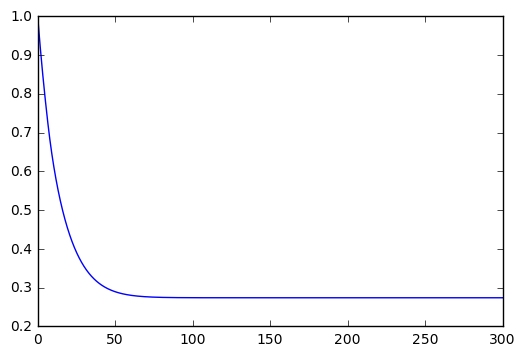

In [4]:
ModelDS.set(ics={'P':1.0})
P=ModelDS.compute('test').sample()
plt.plot(P['t'], P['P'])


100%|██████████████████████████████████████████| 25/25 [00:07<00:00,  3.35it/s]


(0.0, 20000000.0)

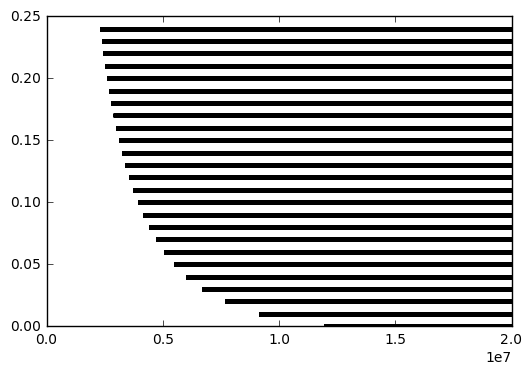

In [5]:
def NC(epsilon, B_M):
    B_MSource = 1e6#1.65e6
    k_AD = 1.5e6
    k_3 = 6e6
    alpha_EM = 0.18
    R_E= 0.0
    k_AT = 0.03
    return(B_MSource - (k_AD*B_M)/(k_3+B_M) - (k_AT*R_E*B_M)/(alpha_EM+R_E)-epsilon*B_M)
E_VALS = np.arange(0.0,0.25,0.01)
B_VALS = np.arange(0.0,20e6,1e2)
E=[]
B=[]
for eps in tqdm(E_VALS):
    for b in B_VALS:
        if NC(eps,b) < 1e-7:
            E.append(eps)
            B.append(b)
plt.plot(B,E,'k.')
plt.ylim(0.0,0.25)
plt.xlim(0.0,20e6)

In [6]:
(1.05*0.1-0.5*0.016)*(5+10.6)/10.6


0.1427547169811321

In [7]:
(0.15*10/((5+10)*0.06)-1)/2

0.33333333333333337

In [48]:
1.067*10.6/0.6

18.85033333333333

In [47]:
(.15*10/(0.03*(15))-1)/2

1.1666666666666667